In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

le = preprocessing.LabelEncoder()

/home/nad/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df=pd.read_csv("housing_prices_grand_tunis.csv")

In [3]:
df.dropna(axis=0, subset=['price','address'], inplace=True)

In [4]:
def fix_price(x):
    if isinstance(x,int) or isinstance(x,float):return x
    if x.split()[-1]=="DT": return int(x[:-3].replace(" ",""))
    if x.split()[-1]=="Nuit": return 30*int(x[:-10].replace(" ",""))
    if x.split()[-1]=="Mois": return int(x[:-10].replace(" ",""))
    if x.split()[-1]=="Semaine": return 4*int(x[:-13].replace(" ",""))
    

In [5]:
def fix_number(x):
    if str(x) == "nan": return x
    if str(x)[-1]=="+": 
        x=int(str(x).strip()[:-1])
    if int(x)>10: 
        x=None
        return x
    return int(x)

In [6]:
def cast_type(x):
#     print(x)
    if x=="vente": return 0
    return 1

In [7]:
# Can be used to filter by type (only keep rent /sale row)
df = df[df.type == 'vente']

In [8]:
# remove DT, /Mois, /Nuit...
df['price']=df['price'].map(fix_price)
# remove '+' signs
df['bathrooms']=df['bathrooms'].map(fix_number)
df['total_rooms']=df['total_rooms'].map(fix_number)
df['rooms']=df['rooms'].map(fix_number)
df['gov']=df['gov'].apply(lambda x: x.strip())
# replace vente/location by 0/1
df['type']=df['type'].map(cast_type)
# if one of the 2 fields is empty try to fill it with the other one
df['rooms'].fillna(df['total_rooms'],inplace=True)
df['total_rooms'].fillna(df['rooms'],inplace=True)
df['living_area'].fillna(df['total_area'],inplace=True)
df['total_area'].fillna(df['living_area'],inplace=True)
# remove row containing any non-appartment-related word
df = df[df['title'].apply(lambda t: True if all(word not in t.split() for word in ["Terrain", "terrain", "أرض", "ارض", "lot", "lots"]) else False)]
# label encoders for gov and address
# df[['gov','address']]=df[['gov','address']].apply(lambda x: le.fit_transform(x))
df = pd.get_dummies(df, columns=['gov', 'address'])


In [9]:
df.loc[df['type']==0,'price']=df.loc[df['type']==0,'price'].apply(lambda x: 1000*x if x<1000 else x)

In [10]:
df['total_rooms'].fillna(df['total_rooms'].median(), inplace=True)
df['rooms'].fillna(df['rooms'].median(), inplace=True)
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df['living_area'].fillna(df['living_area'].median(), inplace=True)
df['total_area'].fillna(df['total_area'].median(), inplace=True)

In [11]:
df

,price,type,title,bathrooms,total_rooms,living_area,total_area,rooms,gov_Ariana,gov_Ben Arous,...,address_Mégrine,address_Oued Ellil,address_Radès,address_Raoued,address_Sidi Daoud,address_Sidi El Béchir,address_Sidi Hassine,address_Sidi Thabet,address_Séjoumi,address_Tebourba
3,170000,0,Appart Kalra,2.0,1.0,90.0,90.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,300000,0,Appart Karma,2.0,3.0,120.0,120.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1150000,0,Loft Panorama,2.0,3.0,360.0,360.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,412000,0,Des appartement haut standing,1.0,4.0,157.0,168.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,950000,0,Av bureau a la marsa,3.0,6.0,50.0,50.0,6.0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,680000,0,Av duplex au jardin de carthage,1.0,4.0,252.0,252.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,504900,0,Av un appartement s3 au jardin de carthage,1.0,4.0,187.0,187.0,4.0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,980000,0,Av duplex gammarth,2.0,4.0,200.0,200.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,1700000,0,Av villa marina gammarth,1.0,4.0,370.0,370.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,545400,0,Av un appartement au jardin de carthage,1.0,4.0,202.0,202.0,4.0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Creating the models

## Linear Regression

In [12]:
x = df[list(filter(lambda x: x not in ['price', 'title', 'type'], df.columns))] # predictor
y = df.price # response
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [13]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
print("Accuracy: ", 100 * linreg.score(x_test,y_test), "%" ) 

Accuracy:  45.74613357446021 %


# Decision Tree

In [15]:
clf = DecisionTreeClassifier(criterion = "entropy",max_depth=5, min_samples_leaf=5)
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
print("Accuracy: ", 100 * clf.score(x_test,y_test), "%" ) 

Accuracy:  6.550218340611353 %


# Random forest

In [17]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
print("Accuracy: ", 100 * rf.score(x_test, y_test), "%" ) 

Accuracy:  82.31176938217631 %


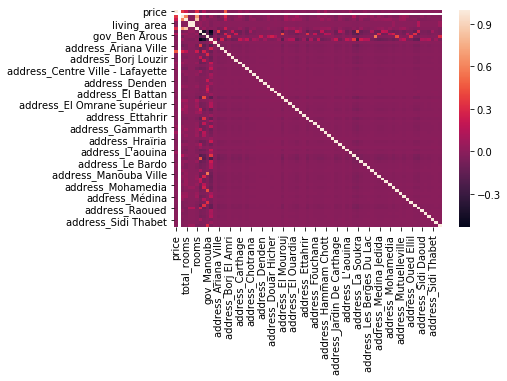

In [19]:
corr = df.corr()
sns.heatmap(corr)


{'whiskers': [<matplotlib.lines.Line2D at 0x7fe7f60ca630>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe7f60cacc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe7f60ca4a8>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe7f60d6390>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe7f60d66d8>],
 'means': []}

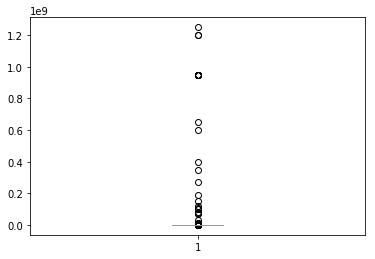

In [20]:
plt.boxplot(df.price)

In [21]:
list(filter(lambda x: x not in ['price', 'title', 'type'], df.columns))


['bathrooms',
 'total_rooms',
 'living_area',
 'total_area',
 'rooms',
 'gov_Ariana',
 'gov_Ben Arous',
 'gov_Manouba',
 'gov_Tunis',
 'address_Agba',
 'address_Ariana Ville',
 'address_Aïn Zaghouan',
 'address_Borj Cedria',
 'address_Borj El Amri',
 'address_Borj Louzir',
 'address_Boumhel',
 'address_Carthage',
 'address_Centre Urbain Nord',
 'address_Centre Ville - Lafayette',
 'address_Chotrana',
 'address_Cité El Khadra',
 'address_Cité Olympique',
 'address_Denden',
 'address_Djebel Jelloud',
 'address_Djedeida',
 'address_Douar Hicher',
 'address_El Battan',
 'address_El Kabaria',
 'address_El Mourouj',
 'address_El Omrane',
 'address_El Omrane supérieur',
 'address_El Ouardia',
 'address_Ennasr',
 'address_Ettadhamen',
 'address_Ettahrir',
 'address_Ezzahra',
 'address_Ezzouhour',
 'address_Fouchana',
 'address_Gammarth',
 'address_Ghazela',
 'address_Hammam Chott',
 'address_Hammam Lif',
 'address_Hraïria',
 'address_Jardin De Carthage',
 "address_Jardins D'el Menzah",
 'addre